# Hurdle in AdaSTEM or AdaSTEM in Hurdle?

Yangkang Chen<br>
Sep 18, 2023

In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Download data

In [3]:
# Please download the sample data from:
# https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745
# Now it'd downloaded and saved as './Sample_data_Mallard.csv'

# you can also try other species like 
# https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751
# https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742
# https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748


In [4]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


# Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data['count'].values


# First thing first: Spatio-temporal train test split

In [6]:
CV = 5

In [7]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle

# Train Hurdle in AdaSTEM

In [8]:
model_hurdle_in_Ada = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),
    save_gridding_plot = True,
    ensemble_fold=10, 
    min_ensemble_required=7,
    grid_len_lon_upper_threshold=25,
    grid_len_lon_lower_threshold=5,
    grid_len_lat_upper_threshold=25,
    grid_len_lat_lower_threshold=5,
    points_lower_threshold=50,
    Spatio1='longitude',
    Spatio2 = 'latitude', 
    Temporal1 = 'DOY',
    use_temporal_to_train=True,
    njobs=4                       
)



  0%|          | 0/5 [00:00<?, ?it/s]

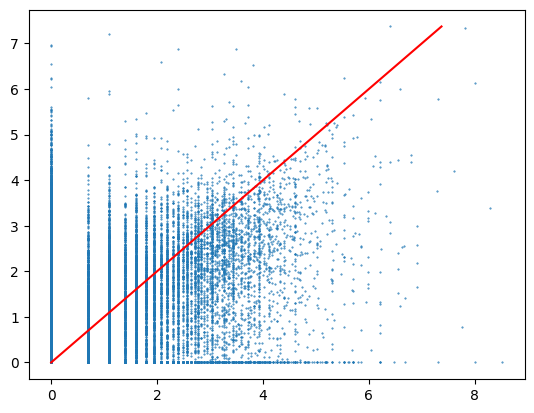

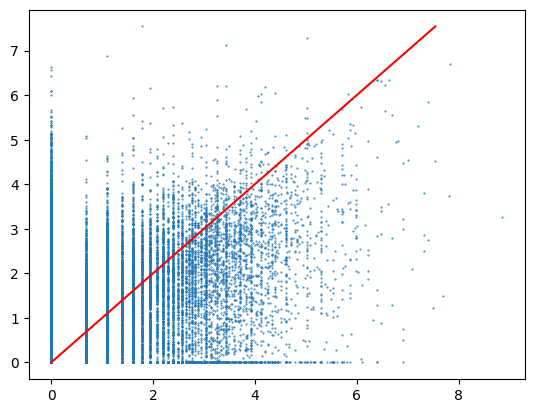

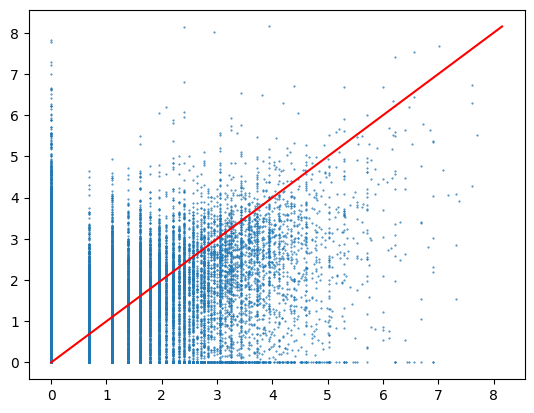

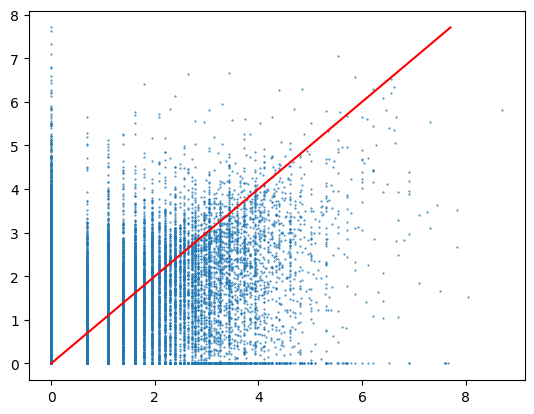

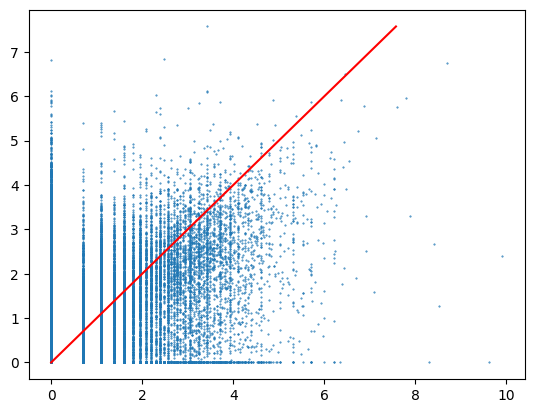

In [9]:
from stemflow.model_selection import ST_CV
CV_generator = ST_CV(X, y, 
                    Spatio_blocks_count = 50, Temporal_blocks_count=50,
                    random_state=42, CV=CV)

metric_dict_list = []
for X_train, X_test, y_train, y_test in tqdm(CV_generator, total=CV):
    ## fit model
    model_hurdle_in_Ada.fit(X_train, y_train, verbosity=0)
    ## predict on test set
    pred_hurdle_in_Ada = model_hurdle_in_Ada.predict(X_test, verbosity=0)
    pred_hurdle_in_Ada = np.where(pred_hurdle_in_Ada<0, 0, pred_hurdle_in_Ada)
    ## calculate metrics
    metrics_hurdle_in_Ada= AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), pred_hurdle_in_Ada.flatten())
    metric_dict_list.append(metrics_hurdle_in_Ada)
    
    # plot
    a = pd.DataFrame({
        'y_true':y_test.flatten(),
        'y_pred':pred_hurdle_in_Ada.flatten()
    }).dropna()
    plt.scatter(np.log(a.y_true+1), np.log(a.y_pred+1), s=0.2)
    plt.plot([0,np.log(a.y_pred+1).max()],[0,np.log(a.y_pred+1).max()], c='red')
    plt.show()
    

In [10]:
hurdle_in_Ada_metrics = pd.DataFrame(metric_dict_list)
hurdle_in_Ada_metrics


AUC     kappa        f1  precision    recall  average_precision  \
0  0.776556  0.399602  0.533535   0.402644  0.790514           0.353562   
1  0.763234  0.378516  0.519680   0.390772  0.775506           0.341389   
2  0.766110  0.384527  0.528265   0.397766  0.786202           0.350321   
3  0.766000  0.386848  0.525204   0.397605  0.773404           0.346218   
4  0.766309  0.381845  0.526306   0.394553  0.790164           0.348524   

   Spearman_r  Pearson_r        R2       MAE          MSE  \
0    0.486733   0.228122  0.004291  4.060732  1547.538014   
1    0.466746   0.200849 -0.006095  4.367535  1690.584790   
2    0.476049   0.212550 -0.686252  4.488267  1561.115758   
3    0.469835   0.158039 -0.091035  4.305906  1755.312096   
4    0.474678   0.107553  0.010033  4.417231  9685.441546   

   poisson_deviance_explained  
0                    0.163586  
1                    0.166015  
2                    0.188853  
3                    0.173555  
4                    0.161657

In [11]:
hurdle_in_Ada_metrics.to_csv('./hurdle_in_Ada_metrics.csv', index=False)

# Train AdaSTEM in Hurdle

In [8]:
model_Ada_in_Hurdle = Hurdle_for_AdaSTEM(
    classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4),
    regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4)
)





  0%|          | 0/5 [00:00<?, ?it/s]

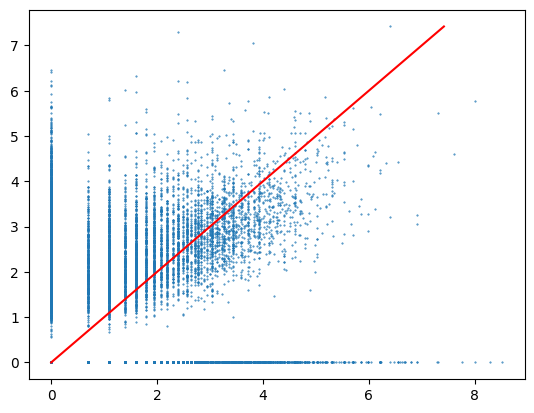

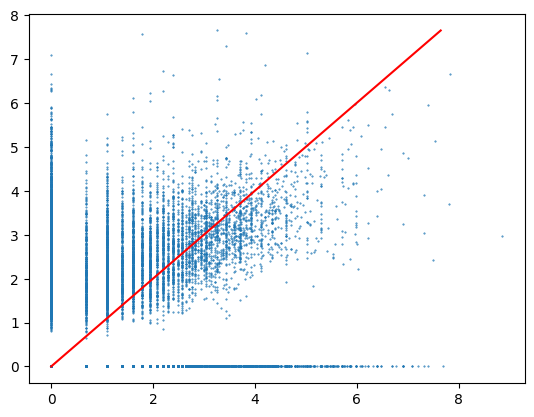

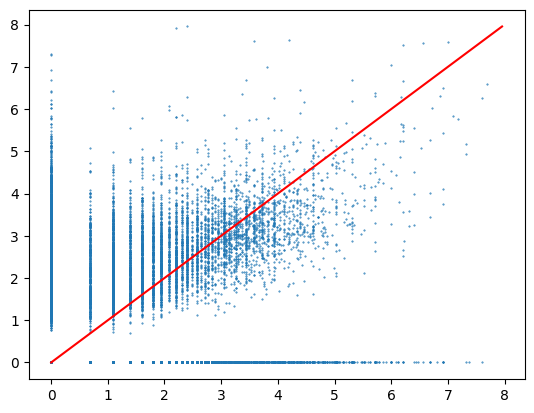

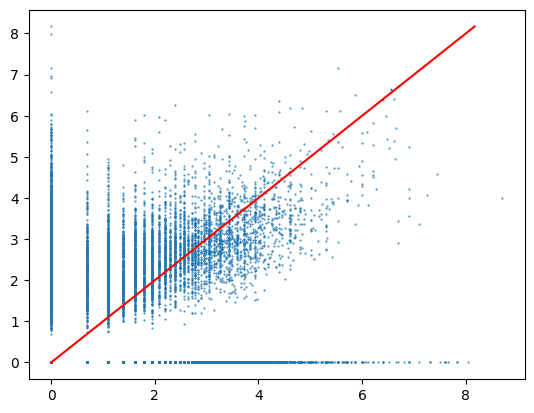

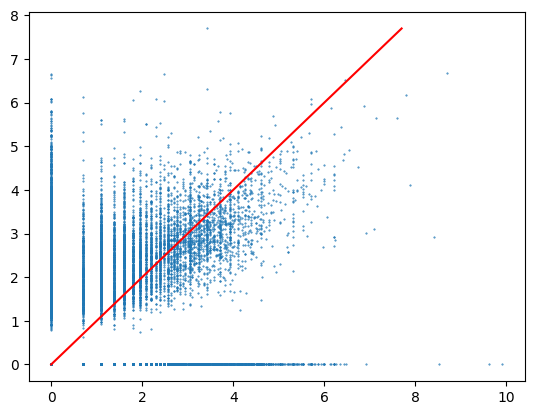

In [10]:
from stemflow.model_selection import ST_CV
CV_generator = ST_CV(X, y, 
                    Spatio_blocks_count = 50, Temporal_blocks_count=50,
                    random_state=42, CV=CV)


metric_dict_list = []
for X_train, X_test, y_train, y_test in tqdm(CV_generator, total=CV):
    ## fit model
    model_Ada_in_Hurdle.fit(X_train, y_train, verbosity=0)
    ## predict on test set
    pred_Ada_in_Hurdle = model_Ada_in_Hurdle.predict(X_test, verbosity=0)
    pred_Ada_in_Hurdle = np.where(pred_Ada_in_Hurdle<0, 0, pred_Ada_in_Hurdle)
    
    ## calculate metrics
    metrics_Ada_in_Hurdle= AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), pred_Ada_in_Hurdle.flatten())
    metric_dict_list.append(metrics_Ada_in_Hurdle)
    
    # plot
    a = pd.DataFrame({
        'y_true':y_test.flatten(),
        'y_pred':pred_Ada_in_Hurdle.flatten()
    }).dropna()
    plt.scatter(np.log(a.y_true+1), np.log(a.y_pred+1), s=0.2)
    plt.plot([0,np.log(a.y_pred+1).max()],[0,np.log(a.y_pred+1).max()], c='red')
    plt.show()
    
    

In [11]:
Ada_in_hurdle_metrics = pd.DataFrame(metric_dict_list)
Ada_in_hurdle_metrics


AUC     kappa        f1  precision    recall  average_precision  \
0  0.697080  0.441068  0.519759   0.613785  0.450714           0.367964   
1  0.680297  0.412394  0.493349   0.607135  0.415482           0.351356   
2  0.690239  0.426277  0.510518   0.606079  0.440988           0.364719   
3  0.684105  0.418367  0.499448   0.607101  0.424224           0.355112   
4  0.688389  0.424938  0.507825   0.609872  0.435032           0.363110   

   Spearman_r  Pearson_r        R2       MAE          MSE  \
0    0.458361   0.141498 -0.061558  3.993602  1541.766283   
1    0.432512   0.138424 -0.138857  4.550810  1919.024133   
2    0.444202   0.266970 -0.431011  4.352729  1226.860455   
3    0.435636   0.114824 -0.209990  4.320640  1940.877595   
4    0.444321   0.097006  0.004345  4.393659  9567.505443   

   poisson_deviance_explained  
0                    0.142712  
1                    0.121617  
2                    0.228450  
3                    0.157750  
4                    0.252556

In [12]:
Ada_in_hurdle_metrics.to_csv('./Ada_in_hurdle_metrics.csv', index=False)

# Compare

In [13]:
hurdle_in_Ada_metrics = pd.read_csv('./hurdle_in_Ada_metrics.csv')
Ada_in_hurdle_metrics = pd.read_csv('./Ada_in_hurdle_metrics.csv')


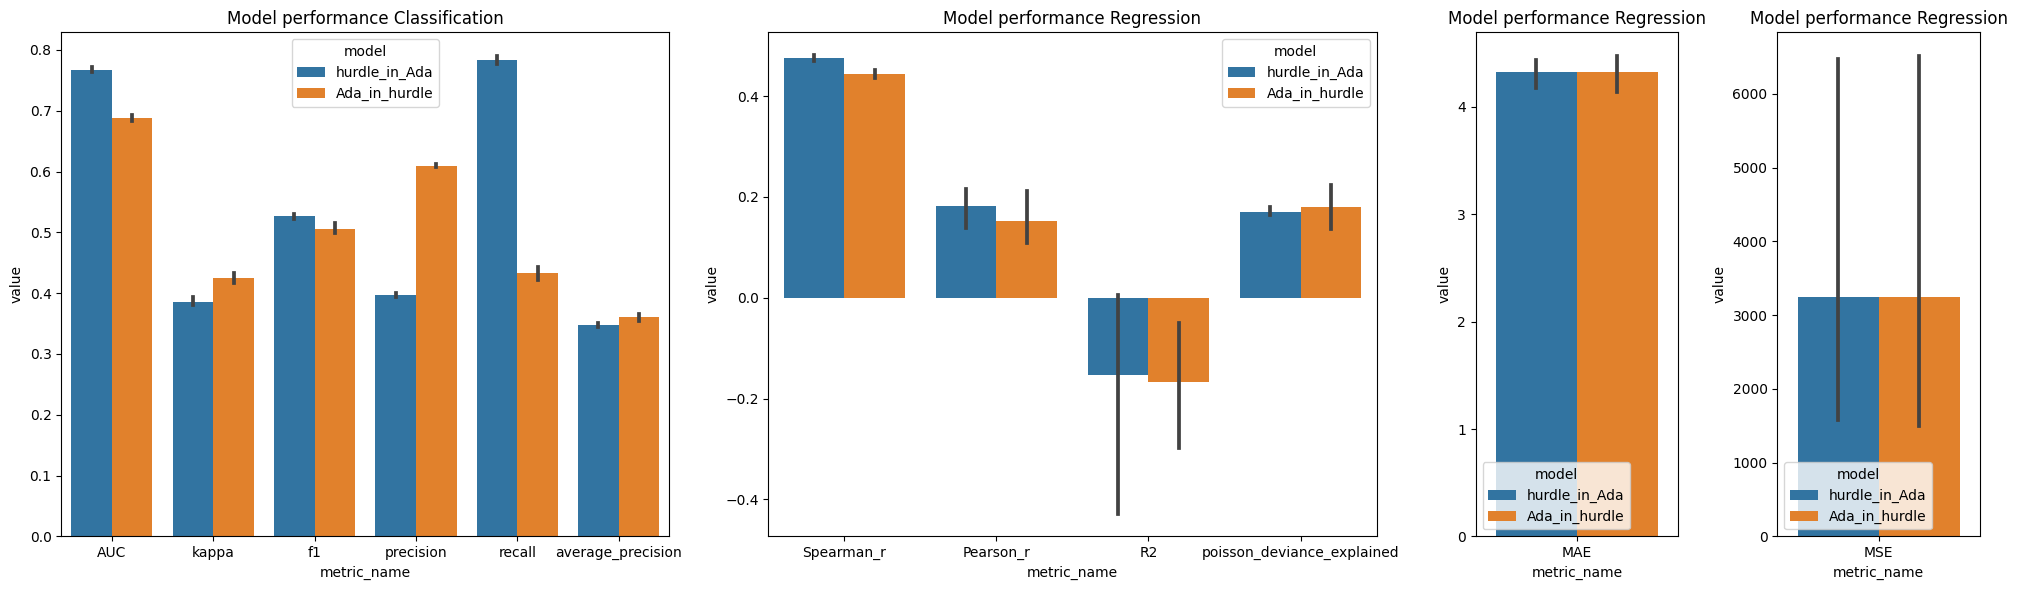

In [49]:
import seaborn as sns
hurdle_in_Ada_metrics['model'] = 'hurdle_in_Ada'
Ada_in_hurdle_metrics['model'] = 'Ada_in_hurdle'
new_dat = pd.concat([hurdle_in_Ada_metrics, Ada_in_hurdle_metrics], axis=0)
dat_for_plot = []
for index,row in new_dat.iterrows():
    for metric_name in ['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision',
                        'Spearman_r', 'Pearson_r', 'R2', 'MAE', 'MSE', 'poisson_deviance_explained']:
        dat_for_plot.append({
            'model':row['model'],
            'metric_name':metric_name,
            'value':row[metric_name]
        })
        
dat_for_plot = pd.DataFrame(dat_for_plot)

# plot
fig, ax = plt.subplots(1, 4, figsize=(20,6), gridspec_kw={'width_ratios': [3, 3, 1, 1]})

### classification
plt.sca(ax[0])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['AUC', 'kappa', 'f1', 'precision', 'recall', 'average_precision'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Classification')

## reg
plt.sca(ax[1])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['Spearman_r', 'Pearson_r', 'R2', 'poisson_deviance_explained'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')

## reg
plt.sca(ax[2])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['MAE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')


## reg
plt.sca(ax[3])
sns.barplot(data=dat_for_plot[
        dat_for_plot.metric_name.isin(['MSE'])
    ], ci=95, 
            x="metric_name", y="value", hue="model")
plt.title('Model performance Regression')
# plt.legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()



We show that:

1. For classification, "Hurdle in Ada" (the one in Johnston, 2015) shows better performance than "Ada in Hurdle" in terms of AUC, F1, and recall, while worse in kappa, precision, and average precision. This shold indicate that hurdle in ada is the choice if you care about occurence in SDM. Recall is more important than precision for the nature of species distribution modeling is to find suitable habitat, and for the fact that imperfect detections are common in observational data.

2. For regression (actually measuring a combination of regression and classification), there is no significant differences for these two modeling methods, except for that "Hurdle in Ada" shows higher spearman's r value.

**Inconclusion, using hurdle model as AdaSTEM base model should be the choice for abundance modeling.**


In [50]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2023-09-19T13:28:59.670936+08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

stemflow    : 0.0.24
numpy       : 1.24.3
scipy       : 1.10.1
pandas      : 2.0.3
xgboost     : 1.7.6
tqdm        : 4.65.0
matplotlib  : 3.7.1
h3pandas    : 0.2.4
geopandas   : 0.11.1
scikit-learn: 0.0

